# Head pose

## Imports

In [33]:
import matplotlib.pyplot as plt
import datagen
import dghelpers
from dghelpers import imshow
import numpy as np

from scipy.spatial.transform import Rotation as R

## Creation of a Dataset container

In [34]:
DATASET_PATH= '../resources/faces_1'
dp = datagen.load(DATASET_PATH)[0]

## Head coordinates system

World to image function definition

In [35]:
world_to_img = lambda x : dghelpers.world_to_img(x, dp.camera_metadata.intrinsic_matrix, dp.camera_metadata.extrinsic_matrix)
extrinsic_rotation = dp.camera_metadata.extrinsic_matrix[:, :3]

### Head pose calculation: Method 1
Let's represent the head rotation as a Scipy Rotation object. Our convention is: **Pitch (x axis) -> Yaw (z axis) -> Roll (y axis)** and the rotation is **intrinsic** (body centered frame of reference)<br> 
This representation will let us convert the head rotation to a rotation matrix, a rotation vector or a quaternion.



In [36]:
head_rotation = dp.actor_metadata.head_metadata.head_rotation

head_rotation_obj = R.from_euler('XZY', [head_rotation.pitch, head_rotation.yaw, head_rotation.roll], degrees=True)
print(f'Matrix conversion: {head_rotation_obj.as_matrix()}')
print(f'Rotation vector conversion: {head_rotation_obj.as_rotvec()}')
print(f'Quaternion conversion: {head_rotation_obj.as_quat()}')

Matrix conversion: [[ 0.97264071  0.23231454  0.        ]
 [-0.22745827  0.95230877  0.20339801]
 [ 0.04725232 -0.19783318  0.97909614]]
Rotation vector conversion: [-0.20388678 -0.0240114  -0.23363488]
Quaternion conversion: [-0.10153301 -0.01195737 -0.11634718  0.98793289]


### Head pose calculation: Method 2
An alternative way to calculate the head rotation is to use the <b>look-at vector</b> and the <b>vector that connects between the eyes</b>. <br>
The vectors are orthogonal. We can calculate a third vector (the <b>up vector</b>) that gives us the head coordinates system by applying a cross-product between the two vectors.<br>
The three vectors make up the rotation matrix that we are looking for. This matrix should be very close to the matrix calculated previously using Yaw/Pitch/Roll.

In [37]:
lookat_vec = dp.actor_metadata.head_metadata.head_six_dof.look_at_vector
eyes_vec = dp.keypoints.face.standard.coords_3d[45] - dp.keypoints.face.standard.coords_3d[36]
eyes_vec /= np.linalg.norm(eyes_vec)
up_vec = np.cross(eyes_vec, -lookat_vec)
head_rot_mat = np.vstack([eyes_vec, -lookat_vec, up_vec]).T
head_rotation_obj = R.from_matrix(head_rot_mat)

### Head pose seen from the camera
If the camera is not frontal, the head pose the camera sees will look different from the head pose calculated previously. Let's find out what is the head pose as the camera sees it.<br>
Our default camera is looking at the Y axis. We therefore begin with a default -90 degrees rotation around the X axis:<br>
<b>extrinsic rotation = (camera rotation $\cdot$ X axis rotation)$^T$ <br>
camera rotation = (extrinsic rotation)$^T$ $\cdot$ (X axis rotation)$^T$</b>

In [38]:
camera_rotation = extrinsic_rotation.T @ R.from_euler('X', -90, degrees=True).as_matrix().T

If the camera is looking frontally, the camera roation matrix is the identity matrix.<br>
To find out the head pose as the camera sees it, we only need to multiply the inverse of the camera rotation with the head pose matrix:

In [39]:
head_rotation_from_camera = camera_rotation.T @ head_rotation_obj.as_matrix()
pitch_cam, yaw_cam, roll_cam = R.from_matrix(head_rotation_from_camera).as_euler('XZY', degrees=True)
print(f'Head pose seen from the camera:\nYaw = {np.around(yaw_cam, decimals=2)}, Pitch = {np.around(pitch_cam, decimals=2)}, Roll = {np.around(roll_cam, decimals=2)}')

Head pose seen from the camera:
Yaw = -13.74, Pitch = -12.08, Roll = 2.8


### Head coordinates system
Let's visualize the head coordinates system - the one that is always centered on the head and rotates along with head - to make sure that our rotation object is correct. <br>
We will first project the head axes onto the image plane using the head rotation matrix and the extrinsic matrix. The resulting matrix columns make up the head coordinates system (X, Y and Z vectors).<br> 
The origin of the coordinates system will be defined as the point between the eyes.<br>

In [40]:
head_X_cam, head_Y_cam, head_Z_cam = (extrinsic_rotation @ head_rotation_obj.as_matrix()).T

We can do the same for the look-at vector.

In [41]:
look_at_cam = extrinsic_rotation @ dp.actor_metadata.head_metadata.head_six_dof.look_at_vector

Let's now plot the coordinates system

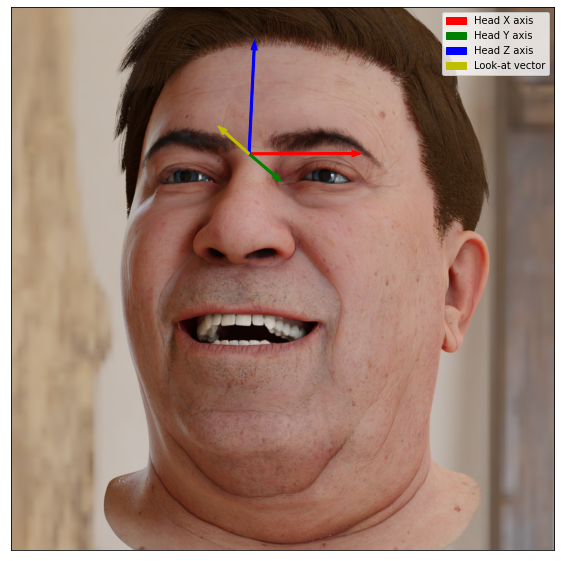

In [42]:
arrow_length = 200

head_location_world = dp.actor_metadata.head_metadata.head_six_dof.location
head_center_cam = world_to_img(head_location_world)

imshow(dp.visible_spectrum)
plt.arrow(*head_center_cam, *(arrow_length * head_X_cam[:2]), color = 'r', label='Head X axis', width=4)
plt.arrow(*head_center_cam, *(arrow_length * head_Y_cam[:2]),  color = 'g', label='Head Y axis', width=4)
plt.arrow(*head_center_cam, *(arrow_length * head_Z_cam[:2]),  color = 'b', label='Head Z axis', width=4)
plt.arrow(*head_center_cam, *(arrow_length * look_at_cam[:2]),  color = 'y', label='Look-at vector', width=4)
plt.legend()